In [10]:
import math
import numpy
from matplotlib import pyplot
%matplotlib inline

In [11]:
Uinf = 1.0                 # free-stream velocity
al = 2.0*math.pi/180       # angle of attack

In [12]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2            # collocation point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.n = [ math.cos(self.beta), math.sin(self.beta)]
        self.t = [-math.sin(self.beta), math.cos(self.beta)]
        
        self.kappa = 1                              # doublet strength
        self.vt = 0                                 # tangential velocity
        self.cp = 0                                 # pressure coefficient

32


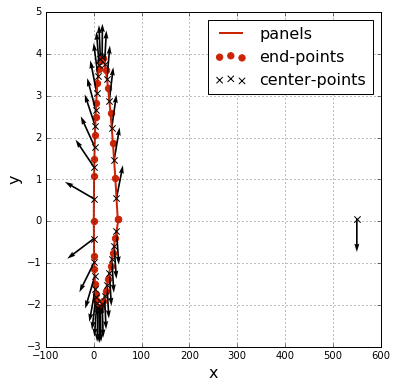

In [38]:
# plot NACA 2510 airfoil
N_panels = 34                   # number of panels desired

with open ('NACA2412_main.csv') as file_name:
    x_ends, y_ends = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

# define the panels
x_ends = numpy.delete(x_ends,[1,N_panels-1])       # delete 2nd and 2nd to last points to merge panels
y_ends = numpy.delete(y_ends,[1,N_panels-1])
N_panels = N_panels - 2

panels = numpy.empty(N_panels+1, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
panels[-1] = Panel(x_ends[0], y_ends[0], x_ends[0]+1000, y_ends[0])

# plot the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x', s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              scale=10, width=0.005)
pyplot.legend(['panels', 'end-points', 'center-points'], loc='best', prop={'size':16})
#pyplot.xlim(-0.75, 0.75)
#pyplot.ylim(-0.5, 0.5);
print(N_panels)

In [33]:
def get_doublet_panel_velocity(p,x,y):
    """Evaluates the velocity components induced at coordinates (x,y) by a panel p.
    
    Arguments
    ---------
    p -- panel from which the velocity is induced
    x -- x-coordinate in global frame
    y -- y-coordinate in global frame
    
    Returns
    -------
    (u,v)-components of velocity at (x,y)
    """
    
    x_p =  math.sin(p.beta)*(x-p.xb) - math.cos(p.beta)*(y-p.yb)
    y_p =  math.cos(p.beta)*(x-p.xb) + math.sin(p.beta)*(y-p.yb)
    
    u_p = -p.kappa/(2*math.pi)*(y_p/(x_p**2+y_p**2) - y_p/((x_p-p.length)**2+y_p**2))
    v_p =  p.kappa/(2*math.pi)*(x_p/(x_p**2+y_p**2) - (x_p-p.length)/((x_p-p.length)**2+y_p**2))
    
    u =  math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u, v

In [34]:
# compute the influence coefficient matrix
A = numpy.zeros((N_panels+1, N_panels+1), dtype=float)

for i, p_i in enumerate(panels[0:N_panels]):
    for j, p_j in enumerate(panels):
        A[i,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
        if i == j:
            A[i,j] *= 1.001
A[-1,0] = -1
A[-1,-2] = 1
A[-1,-1] = -1

# compute the RHS of the linear system
b = numpy.zeros((N_panels+1, 1), dtype=float)
for i, p_i in enumerate(panels[0:N_panels]):
    b[i] = -numpy.dot(numpy.array([Uinf*math.cos(al), Uinf*math.sin(al)]), p_i.n)
    
print (A)
print (b)

[[ 0.1250951  -0.04159022 -0.00833433 ...,  0.03079948 -0.11206199
   0.06232923]
 [-0.04193172  0.12571036 -0.04181215 ..., -0.07541068  0.02454684
   0.02070482]
 [-0.00841516 -0.04206604  0.1261678  ...,  0.01081481  0.00711594
   0.01238402]
 ..., 
 [ 0.02556395 -0.07687845  0.01272877 ...,  0.12715763 -0.0423445
  -0.02098162]
 [-0.11170218  0.02935205  0.00733771 ..., -0.04233969  0.12714896
  -0.06295874]
 [-1.          0.          0.         ...,  0.          1.         -1.        ]]
[[-0.22553277]
 [-0.19904132]
 [-0.17602176]
 [-0.15177461]
 [-0.12237298]
 [-0.09072324]
 [-0.04289325]
 [ 0.00706869]
 [ 0.04689316]
 [ 0.09422842]
 [ 0.15797531]
 [ 0.22499724]
 [ 0.28177493]
 [ 0.38289282]
 [ 0.52845464]
 [ 0.84643935]
 [ 0.81768091]
 [ 0.4753388 ]
 [ 0.31711851]
 [ 0.21139258]
 [ 0.14982418]
 [ 0.1046009 ]
 [ 0.06086309]
 [ 0.03290065]
 [ 0.0149087 ]
 [ 0.0029175 ]
 [-0.01106079]
 [-0.02302647]
 [-0.02701087]
 [-0.02900218]
 [-0.03298291]
 [-0.03397768]
 [ 0.        ]]


In [35]:
# solves the linear system
kappa = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.kappa = float(kappa[i])
print (kappa)

[[-100.56951445]
 [ -96.65690363]
 [ -92.21831137]
 [ -87.51182085]
 [ -82.58559789]
 [ -77.50308043]
 [ -72.31024424]
 [ -68.11975108]
 [ -64.75201738]
 [ -61.50263631]
 [ -58.34228984]
 [ -55.91980495]
 [ -54.02806013]
 [ -52.21492339]
 [ -50.76578329]
 [ -49.49089978]
 [ -49.10825894]
 [ -49.77032421]
 [ -50.71307991]
 [ -52.02352172]
 [ -53.4479438 ]
 [ -55.28802042]
 [ -57.71950359]
 [ -60.24324714]
 [ -62.86685012]
 [ -66.11502899]
 [ -70.16729796]
 [ -74.24698213]
 [ -78.26103018]
 [ -82.18843853]
 [ -86.02717804]
 [ -89.6442844 ]
 [  10.92523005]]


In [36]:
for i, p_i in enumerate(panels[0:N_panels]):
    vt = numpy.array([0])
    for j, p_j in enumerate(panels):
        if i != j:
            vt = vt + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
    if i == 0:
        R = math.sqrt((panels[1].xc-panels[0].xc)**2 + (panels[1].yc-panels[0].yc)**2)
        vt = vt - 0.5*(panels[1].kappa-panels[0].kappa)/R
    elif i == N_panels-1:
        R = math.sqrt((panels[N_panels-1].xc-panels[N_panels-2].xc)**2 + (panels[N_panels-1].yc-panels[N_panels-2].yc)**2)
        vt = vt - 0.5*(panels[N_panels-1].kappa-panels[N_panels-2].kappa)/R
    else:
        R = math.sqrt((panels[i+1].xc-panels[i-1].xc)**2 + (panels[i+1].yc-panels[i-1].yc)**2)
        vt = vt - 0.5*(panels[i+1].kappa-panels[i-1].kappa)/R
    vt = vt + numpy.dot(numpy.array([Uinf*math.cos(al), Uinf*math.sin(al)]), p_i.t)
    p_i.vt = float(vt)
    p_i.cp = 1.0 - (p_i.vt/Uinf)**2

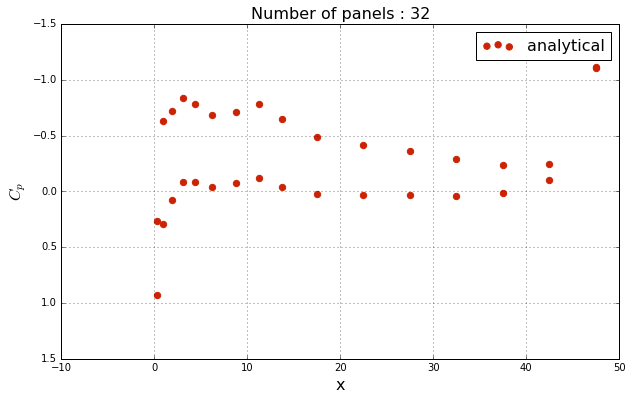

In [37]:
# plots the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)

pyplot.scatter([p.xc for p in panels[0:N_panels]], [p.cp for p in panels[0:N_panels]], color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(['analytical', 'source panel method'], loc='best', prop={'size':16})
#pyplot.xlim(-0.6, 0.6)
#pyplot.ylim(-1, 1.5)
pyplot.gca().invert_yaxis();